In [3]:
import numpy as np
import pandas as pd
import skimage
import skimage.io
import os
import os.path as osp
import re
import tables
import sklearn as skl
import sklearn.neighbors
import scipy
import scipy.spatial.distance as sp
import scipy.stats as st
import matplotlib.pyplot as plt
import tqdm
import bokeh
import bokeh.io
import bokeh.plotting
import distance

bokeh.io.output_notebook()

Loading BokehJS ...

# Deep analysis of 3 model regions in original 25kb data

1. Try to reproduce Long's analysis - Normalize IF, pixelwise IF correlation versus locus contact frequency (binary)
2. Ways to detect loops, boundaries (insulation scores, probabilities), long-range interactions
3. Surfaces and voids

Yodai recommended Chr1, 5 and 6 25kb regions as models because Chr1 is gene rich with superenhancers; Chr5 has a very long gene, Auts2; Chr6 has loops and "strips"

## Load DNA data

In [4]:
base_dir = '~/CaiLab/dna-if-analysis/'
df_1 = pd.read_csv(
    osp.join(base_dir, 'data/DNAseqFISH+25kbloci-E14-replicate1.csv'),
    usecols=['fov', 'cellID', 'regionID (hyb1-60)', 'x', 'y', 'z', 'chromID', 'labelID']
)

df_1['rep'] = 1

df_2 = pd.read_csv(
    osp.join(base_dir, 'data/DNAseqFISH+25kbloci-E14-replicate2.csv'),
    usecols=['fov', 'cellID', 'regionID (hyb1-60)', 'x', 'y', 'z', 'chromID', 'labelID']
)

df_2['rep'] = 2

dna_25 = pd.concat([df_1, df_2])

del df_1, df_2

order = pd.read_csv(osp.join(base_dir, 'data/TableS0_25kbcoords.csv'))

In [5]:
dna_25.head()

fov  cellID  regionID (hyb1-60)            x           y          z  \
0    0       1                   2  1718.431196  146.909289  11.282036   
1    0       1                   3  1717.986519  146.171951  11.083011   
2    0       1                   3  1604.490932  204.195855  11.725510   
3    0       1                   5  1718.106776  146.904642  10.363083   
4    0       1                   5  1600.751787  204.916308  13.133202   

   chromID  labelID  rep  
0        1        0    1  
1        1        0    1  
2        1        1    1  
3        1        0    1  
4        1        1    1

In [6]:
order.head(5)

Region ID             Name  Channel Chrom      Start        End  Chrom ID
0          1  chr1-HighRes-#1        3  chr1  135600000  135625000         1
1          2  chr1-HighRes-#2        3  chr1  135625000  135650000         1
2          3  chr1-HighRes-#3        3  chr1  135650000  135675000         1
3          4  chr1-HighRes-#4        3  chr1  135675000  135700000         1
4          5  chr1-HighRes-#5        3  chr1  135700000  135725000         1

In [402]:
chr_156 = dna_25.query('chromID in [1, 5, 6]').copy()

In [403]:
chr_156['xpx'] = chr_156['x'].round().astype(np.uint16)
chr_156['ypx'] = chr_156['y'].round().astype(np.uint16)
chr_156['zpx'] = chr_156['z'].round().astype(np.uint16)

chr_156['xnm'] = 103*chr_156['x']
chr_156['ynm'] = 103*chr_156['y']
chr_156['znm'] = 250*chr_156['z']

In [404]:
chr_156.head()

fov  cellID  regionID (hyb1-60)            x           y          z  \
0    0       1                   2  1718.431196  146.909289  11.282036   
1    0       1                   3  1717.986519  146.171951  11.083011   
2    0       1                   3  1604.490932  204.195855  11.725510   
3    0       1                   5  1718.106776  146.904642  10.363083   
4    0       1                   5  1600.751787  204.916308  13.133202   

   chromID  labelID  rep   xpx  ypx  zpx            xnm           ynm  \
0        1        0    1  1718  147   11  176998.413188  15131.656798   
1        1        0    1  1718  146   11  176952.611457  15055.710912   
2        1        1    1  1604  204   12  165262.565996  21032.173096   
3        1        0    1  1718  147   10  176964.997928  15131.178147   
4        1        1    1  1601  205   13  164877.434061  21106.379765   

           znm  
0  2820.508940  
1  2770.752832  
2  2931.377597  
3  2590.770663  
4  3283.300545

## Associate IF intensities in nearest voxel to each DNA locus



In [405]:
rep2folder = ('', 'Rep2-2', 'Rep3-1')

merged_temp = []
missing_if = []

for info, cell_dna in chr_156.groupby(['rep', 'fov', 'cellID']):
    rep, pos, cell = info
    
    filename = '../../IF_converted/{0}/IF_Rep{1}_Pos{2}_Cell{3}_wide.hd5'.format(rep2folder[rep], rep, pos, cell)
    
    try:
        cell_if = pd.read_hdf(filename)
    except OSError:
        missing_if.append(filename)
        continue
    
    cell_merged = pd.merge(
        cell_dna, 
        cell_if, 
        left_on=('xpx', 'ypx', 'zpx'), 
        right_on=('xIdx', 'yIdx', 'zIdx'),
        how='left',
    )
    
    merged_temp.append(cell_merged)

chr_156_if = pd.concat(merged_temp)

KeyboardInterrupt: 

In [ ]:
len(merged_temp), len(missing_if)

In [ ]:
del merged_temp

### Save new file

In [ ]:
chr_156_if.to_csv('./Chr1-5-6_25kb_IF_merged.csv', index=False)

## Pick back up

In [7]:
chr_156_if = pd.read_csv('Chr1-5-6_25kb_IF_merged.csv')

### Normalizing IF

1. Sum every stain within each pixel 
1. Sum within each stain over all pixels in a cell, divide that stain at each pixel by that sum (each stain sums to 1 in each cell)
    a. Alternative: compute Z score within each stain within each cell (then they sum to 0)


In [8]:
chr_156_if.columns

Index(['fov', 'cellID', 'regionID (hyb1-60)', 'x', 'y', 'z', 'chromID',
       'labelID', 'rep', 'xpx', 'ypx', 'zpx', 'xnm', 'ynm', 'znm', 'zIdx',
       'xIdx', 'yIdx', 'LINE1', 'Telomere', 'MinSat', 'mH2A1', 'H3pSer10',
       'H3K9ac', 'H3K9me2', 'H3K9me3', 'H4K20me2', 'Fibrillarin',
       'RNAPII Ser5-P', 'H3K27ac', 'H4K20me1', 'SINEB1', 'H3K27me2', 'SF3a66',
       'H3K27me3', 'H4K20me3', 'Lamin B1', 'H4K16ac', 'DAPI'],
      dtype='object')

In [9]:
stains = chr_156_if.columns.difference(['fov', 'cellID', 'regionID (hyb1-60)', 
                                        'chromID', 'labelID', 'rep',
                                        'x', 'y', 'z',
                                        'xpx', 'ypx', 'zpx',
                                        'xnm', 'ynm', 'znm',
                                        'xIdx', 'yIdx', 'zIdx'
                                       ], sort=False)
stains

Index(['LINE1', 'Telomere', 'MinSat', 'mH2A1', 'H3pSer10', 'H3K9ac', 'H3K9me2',
       'H3K9me3', 'H4K20me2', 'Fibrillarin', 'RNAPII Ser5-P', 'H3K27ac',
       'H4K20me1', 'SINEB1', 'H3K27me2', 'SF3a66', 'H3K27me3', 'H4K20me3',
       'Lamin B1', 'H4K16ac', 'DAPI'],
      dtype='object')

In [10]:
stains_dist = pd.Index(['regionID (hyb1-60)', 'xnm', 'ynm', 'znm'] + list(stains))
stains_dist

Index(['regionID (hyb1-60)', 'xnm', 'ynm', 'znm', 'LINE1', 'Telomere',
       'MinSat', 'mH2A1', 'H3pSer10', 'H3K9ac', 'H3K9me2', 'H3K9me3',
       'H4K20me2', 'Fibrillarin', 'RNAPII Ser5-P', 'H3K27ac', 'H4K20me1',
       'SINEB1', 'H3K27me2', 'SF3a66', 'H3K27me3', 'H4K20me3', 'Lamin B1',
       'H4K16ac', 'DAPI'],
      dtype='object')

In [11]:
def if_normalize_cell(cell_df, columns, method='density', pixelwise=False):
    result = cell_df.copy()
    
    if pixelwise:
        pixel_sums = result[columns].sum(axis=1)
        result[columns] = result[columns].divide(pixel_sums, axis=0)
    
    if method.lower() == 'density':
        result[columns] = result[columns] / result[columns].sum()
    elif method.lower() == 'z':
        result[columns] = (result[columns] - result[columns].mean()) / result[columns].std()
    elif method.lower() == 'minmax':
        result[columns] = (result[columns] - result[columns].min()) / (result[columns].max() - result[columns].min())
    else:
        raise ValueError('`method` must be one of `density`, `z`, `minmax`')
    
    return result

def if_normalize(df, columns, method='density', within_cell=True, pixelwise=False):
    
    if within_cell:
        result_temp = []
        
        for info, group in df.groupby(['rep', 'fov', 'cellID']):            
            result_temp.append(if_normalize_cell(group, columns, method, pixelwise))
        
        result = pd.concat(result_temp)
        del result_temp
    else:
        # could we want to group by rep and fov but not cellID?
        result = if_normalize_cell(df, columns, method, pixelwise)
    
    return result

In [12]:
chr_156_if_norm = if_normalize(chr_156_if, stains, method='density', pixelwise=True)

In [13]:
chr_156_if_norm['DAPI'].sum()

326.0

In [108]:
chr_156_if_norm.to_csv('Chr1-5-6_25kb_IF_dens_normalized.csv', index=False)

In [14]:
def fetch_cell_allele(rep, fov, cell, chrom, label):
    celldata = chr_156_if_norm.query(f'rep=={rep} & fov=={fov} & cellID=={cell}').copy()

    return celldata.query(f'chromID=={chrom} & labelID=={label}')

In [15]:
test_allele = fetch_cell_allele(2, 3, 10, 6, 0)

h3k27ac, h3k9ac, sf3a66, rna pol,
long gene

In [16]:
test_allele

fov  cellID  regionID (hyb1-60)            x            y         z  \
67952    3      10                   1  1141.596579  1068.799085  5.442142   
67953    3      10                   1  1146.571075  1072.094002  6.457348   
67954    3      10                   2  1145.322352  1071.123357  5.620996   
67956    3      10                   3  1144.289089  1070.173843  5.563145   
67958    3      10                   4  1145.279804  1068.691530  5.462245   
...    ...     ...                 ...          ...          ...       ...   
68076    3      10                  55  1140.167532  1067.237708  6.222545   
68079    3      10                  56  1140.901547  1065.910935  6.292866   
68084    3      10                  58  1141.313617  1065.238282  6.678877   
68087    3      10                  59  1139.600681  1066.347172  6.521641   
68088    3      10                  60  1139.077975  1066.156636  6.474016   

       chromID  labelID  rep   xpx  ...   H3K27ac  H4K20me1    SINEB1  \
67952        6        0    2  1142  ...  0.002972  0.003115  0.002568   
67953        6        0    2  1147  ...  0.003163  0.002727  0.002495   
67954        6        0    2  1145  ...  0.002938  0.002731  0.002321   
67956        6        0    2  1144  ...  0.002981  0.002561  0.002440   
67958        6        0    2  1145  ...  0.003182  0.002943  0.002026   
...        ...      ...  ...   ...  ...       ...       ...       ...   
68076        6        0    2  1140  ...  0.003003  0.002440  0.003017   
68079        6        0    2  1141  ...  0.003135  0.002533  0.003120   
68084        6        0    2  1141  ...  0.003224  0.002442  0.002885   
68087        6        0    2  1140  ...  0.003239  0.002348  0.003101   
68088        6        0    2  1139  ...  0.002979  0.002414  0.002611   

       H3K27me2    SF3a66  H3K27me3  H4K20me3  Lamin B1   H4K16ac      DAPI  
67952  0.002341  0.002748  0.002174  0.002783  0.004538  0.002989  0.003123  
67953  0.001970  0.005290  0.001905  0.003315  0.003917  0.002257  0.003718  
67954  0.002130  0.004674  0.002015  0.002865  0.004695  0.002737  0.003429  
67956  0.002227  0.004562  0.002298  0.003018  0.004683  0.002568  0.003236  
67958  0.002088  0.006299  0.001984  0.002997  0.004708  0.002501  0.003406  
...         ...       ...       ...       ...       ...       ...       ...  
68076  0.002443  0.001694  0.002068  0.002133  0.003192  0.003060  0.003310  
68079  0.002414  0.002164  0.002035  0.002267  0.002872  0.003014  0.003161  
68084  0.002680  0.002048  0.002348  0.002283  0.002856  0.003166  0.001940  
68087  0.002515  0.001697  0.002048  0.002072  0.003070  0.003031  0.001874  
68088  0.002552  0.001807  0.002069  0.001999  0.003185  0.003169  0.002839  

[67 rows x 39 columns]

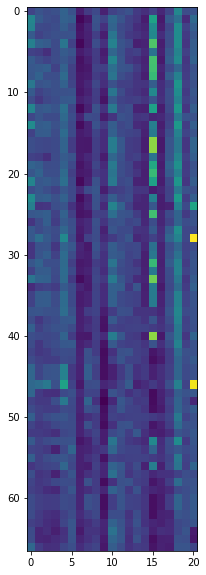

In [17]:
fig, ax = plt.subplots(figsize=(5,10))

plt.imshow(test_allele[stains].values)

plt.show()

In [18]:
def composite_dist(regions, coords, stains, return_comps=False):   
    regions = np.atleast_2d(regions).T
    reg_dist = (1/59)*sp.squareform(sp.pdist(regions, metric='cityblock'))
    
    space_dist = sp.squareform(sp.pdist(coords, metric='euclidean'))
    space_dist = space_dist / space_dist.max().max()
    
    stain_dist = sp.squareform(sp.pdist(stains, metric='cityblock'))
    stain_dist = stain_dist / stain_dist.max().max()
    
    if return_comps:
        return reg_dist, space_dist, stain_dist
    
    return (1/3)*(reg_dist + space_dist + stain_dist)

In [19]:
test_if_corr = 1 - test_allele[stains].T.corr(method='spearman')

In [20]:
test_if_dist = sp.squareform(sp.pdist(test_allele[stains].values, metric='cityblock'))

In [21]:
test_comp_dist = composite_dist(
    test_allele['regionID (hyb1-60)'].values,
    test_allele[['xnm', 'ynm', 'znm']].values,
    test_allele[stains].values,
    return_comps=True
)

In [22]:
test_if_corr.max().max()

1.1077922077922078

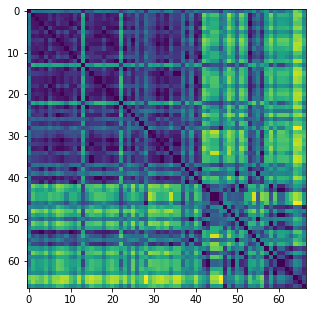

In [23]:
fig, ax = plt.subplots(figsize=(5,10))

plt.imshow(test_if_corr.values)

plt.show()

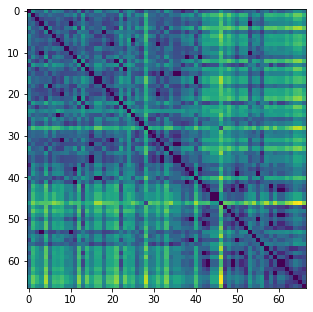

In [24]:
fig, ax = plt.subplots(figsize=(5,10))

plt.imshow(test_if_dist)

plt.show()

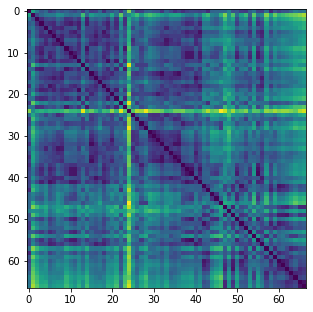

In [25]:
fig, ax = plt.subplots(figsize=(5,10))

plt.imshow(test_comp_dist[1]+test_comp_dist[1])

plt.show()

In [26]:
comp_vecs = [ sp.squareform(m) for m in test_comp_dist ]

In [27]:
from bokeh.models import ColorBar, ColumnDataSource
from bokeh.palettes import Viridis256
from bokeh.plotting import figure, output_file, show
from bokeh.transform import linear_cmap

#Use the field name of the column source
mapper = linear_cmap(field_name='z', palette=Viridis256,low=0 ,high=10)

source = ColumnDataSource(dict(x=comp_vecs[1],y=comp_vecs[2], z=10*comp_vecs[0]))

p = figure(x_axis_label='Spatial distance', y_axis_label='Stain distance')

p.circle(x='x', y='y', color=mapper, source=source, alpha=1, size='z')

color_bar = ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0))

p.add_layout(color_bar, 'right')

show(p)



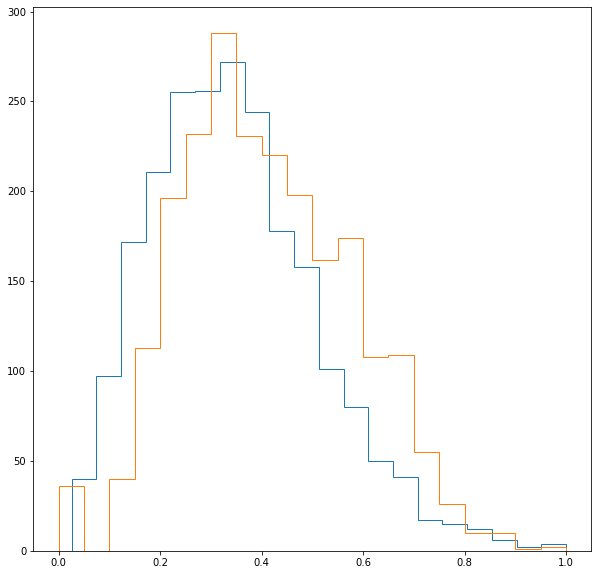

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.hist(comp_vecs[1], cumulative=False, bins=20, histtype='step')
plt.hist(comp_vecs[2], cumulative=False, bins=20, histtype='step')

plt.show()

In [29]:
test_dna_dist = sp.squareform(sp.pdist(test_allele[['xnm', 'ynm', 'znm']]))

test_dist_thresh = test_dna_dist < 120

In [30]:
test_dna_dist.max()

1136.56294350202

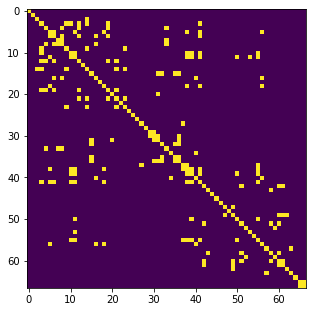

In [31]:
fig, ax = plt.subplots(figsize=(5,10))

plt.imshow(test_dist_thresh)

plt.show()

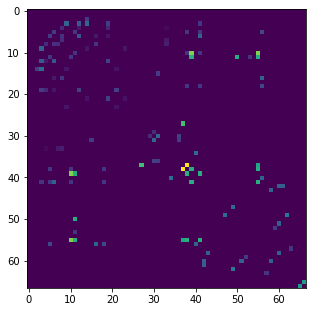

In [32]:
fig, ax = plt.subplots(figsize=(5,10))

plt.imshow(test_if_corr.values * (test_dist_thresh))

plt.show()

# Graphs/filtrations

Maybe equally/more informative to just use persistent homology and a filtration to analyze progression of connectivity as you change radius of search.

In [431]:
test_dist_thresh = test_dna_dist < 100

In [ ]:
import igraph as ig
import networkx as nx

In [ ]:
obo = np.where(test_dna_dist<400, test_dna_dist, np.full(test_dna_dist.shape, np.nan))

In [ ]:
g = ig.Graph.Weighted_Adjacency(list(obo), mode=ig.ADJ_UNDIRECTED)

In [ ]:
g.vs

In [ ]:
layout = g.layout('kk')
ig.plot(g,bbox=(500, 500))

In [33]:
import gudhi

In [34]:
def rips_pers(pts=None, distance_matrix=None, max_dimension=1, max_edge_length=np.inf):
    
    if distance_matrix is not None:
        rips = gudhi.RipsComplex(distance_matrix=distance_matrix)
    else:
        rips = gudhi.RipsComplex(points=pts, max_edge_length=max_edge_length)
    
    simplex = rips.create_simplex_tree(max_dimension=max_dimension)
    
    simplex.compute_persistence(homology_coeff_field=11)
    
    return simplex

def alpha_pers(pts, max_alpha_square=np.inf):
    
    alpha = gudhi.AlphaComplex(points=pts)
    
    simplex = alpha.create_simplex_tree(max_alpha_square=max_alpha_square)
    
    simplex.compute_persistence(homology_coeff_field=11)
    
    return simplex

In [35]:
cell_info = (2, 3, 11) # rep, fov, cellID
chroms = (1, 5, 6)
labels = (0, 1)

alleles = [ (c, l) for c in chroms for l in labels]

### Spatial persistence

In [90]:
chr6l0_data = fetch_cell_allele(*cell_info, 6, 0)[['xnm', 'ynm', 'znm']]
alphat = gudhi.RipsComplex(chr6l0_data.values)
perst = alphat.create_simplex_tree(max_dimension=2)
perst.compute_persistence()

In [101]:
tan = gudhi.TangentialComplex(2, points=chr6l0_data.values)

tan.compute_tangential_complex()
tan.num_inconsistent_simplices()
stan = tan.create_simplex_tree()

In [107]:
stan.compute_persistence()
stan.persistence()

[(1, (0.0, inf)),
 (1, (0.0, inf)),
 (1, (0.0, inf)),
 (1, (0.0, inf)),
 (1, (0.0, inf)),
 (0, (0.0, inf))]

In [51]:
chr6l0_data['znm'].max() - chr6l0_data['znm'].min()

1413.5090015

In [52]:
#### For an alphacomplex only, the order of vertices in the simplex tree
#### is NOT necessarily the same as in the input! Need to save the AlphaComplex
#### object and use this function to retrieve the coordinates. Then find this in the input DF. Yuck
point_ex = alphat.get_point(13)
chr6l0_data.query(f'xnm=={point_ex[0]} & ynm=={point_ex[1]} & znm=={point_ex[2]}')

AttributeError: 'gudhi.rips_complex.RipsComplex' object has no attribute 'get_point'

In [53]:
perst.find([1, 5])

True

This function tells you which simplices of a given dimension (or 0 for all) a given simplex (or just vertex) is part of.
We could use this to look up a particular locus of interest (e.g., an enhancer or promoter), and then sort the filtration values.


In [62]:
pd.DataFrame(perst.get_cofaces([1], 1), 
             columns=['Simplex', 'Filtration']).sort_values(by='Filtration')

Simplex   Filtration
62  [1, 63]   132.575870
65  [1, 66]   134.735150
0    [0, 1]   159.555768
51  [1, 52]   162.527009
6    [1, 7]   163.675839
..      ...          ...
10  [1, 11]   815.362361
44  [1, 45]   834.748198
24  [1, 25]   905.283073
55  [1, 56]   939.050654
22  [1, 23]  1420.628284

[83 rows x 2 columns]

In [74]:
perst.persistent_betti_numbers(200, 350)

[3, 0]

In [441]:
np.max(sp.pdist(randtest))

1377.250241863985

Maybe alpha complex discriminates against random points a little better? Seems to have fewer instances of highly persistent individual connected components. But I think I will need to do some bootstrapping to make this more robust anyway.

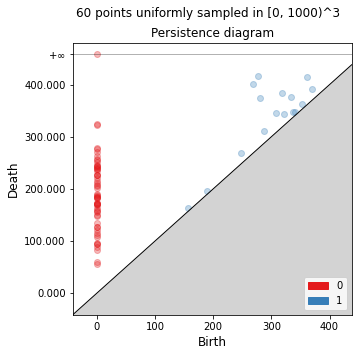

In [123]:
randtest = np.random.uniform(low=0, high=1000, size=(60, 3))
randpers = rips_pers(randtest, max_dimension=2)

fig, ax = plt.subplots(figsize=(5, 5))
fig.suptitle('60 points uniformly sampled in [0, 1000)^3')
gudhi.plot_persistence_diagram(randpers.persistence(), fontsize=12, legend=True, axes=ax, alpha=0.3)
plt.show()

In [120]:
expers

[[], [], [], []]

In [81]:
persistences = []

for allele in alleles:
    celldata = fetch_cell_allele(*cell_info, *allele)
    pts = celldata[['xnm', 'ynm', 'znm']].values
    
    pers = rips_pers(pts, max_dimension=2)
    persistences.append(pers)
    

In [87]:
[ p.persistent_betti_numbers(300, 1000) for p in persistences ]

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]

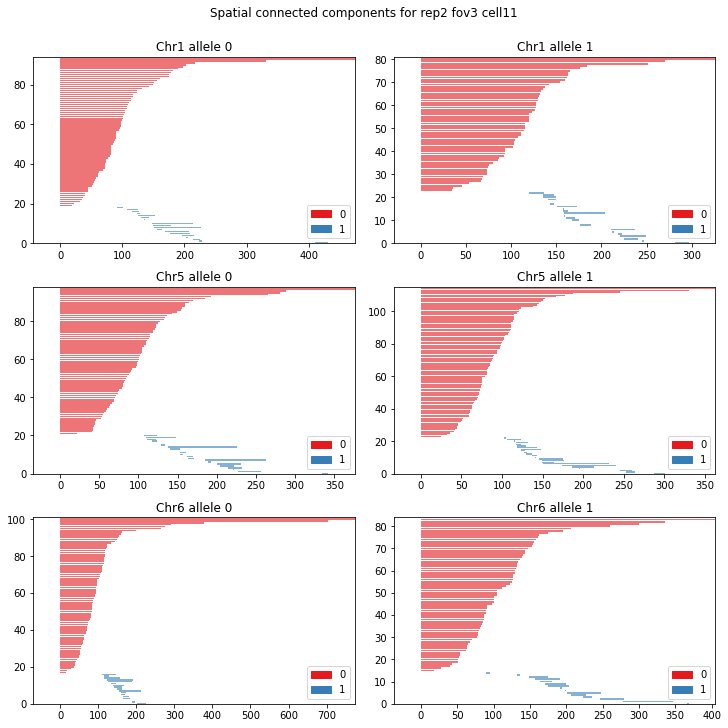

In [83]:
fig, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
fig.suptitle(f'Spatial connected components for rep{cell_info[0]} fov{cell_info[1]} cell{cell_info[2]}')
fig.set_size_inches((10, 10))
for p, a, al in zip(persistences, axes.ravel(), alleles):
    gudhi.plot_persistence_barcode(p.persistence(), axes=a, legend=True, fontsize=12)
    #a.set_xlim(-50, 500)
    #a.set_ylim(-50, 500)
    a.set_title(f'Chr{al[0]} allele {al[1]}')

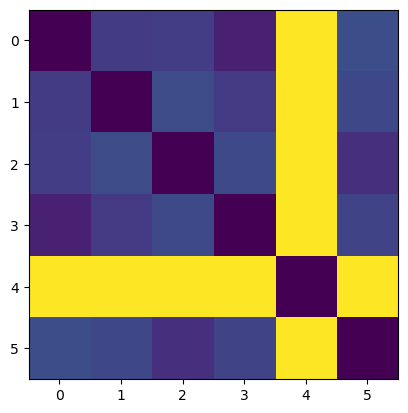

In [312]:
from gudhi.representations.metrics import pairwise_persistence_diagram_distances as ppddist
fig, ax = plt.subplots()

plt.imshow(ppddist(persistences, metric='bottleneck'))

plt.show()

### Stain persistence

20 dimensional space with city block distance

In [88]:
stain_persistences = []

for allele in alleles:
    celldata = fetch_cell_allele(*cell_info, *allele)
    
    pts = celldata[stains].values
    dist_mat = sp.squareform(sp.pdist(pts, metric='cityblock'))
    
    pers = rips_pers(distance_matrix=dist_mat, max_dimension=2).persistence()
    
    stain_persistences.append(pers)
    

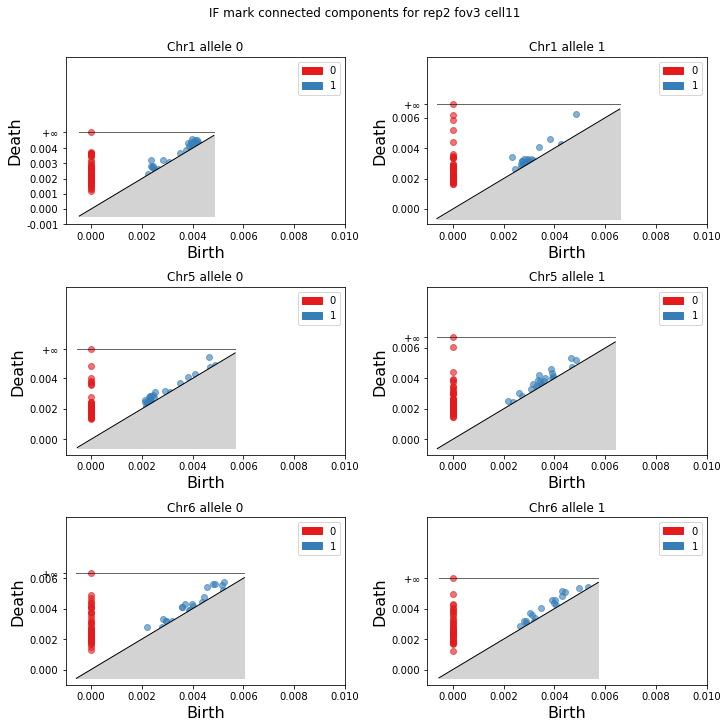

In [89]:
fig, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
fig.suptitle(f'IF mark connected components for rep{cell_info[0]} fov{cell_info[1]} cell{cell_info[2]}')
fig.set_size_inches((10, 10))
for p, a, al in zip(stain_persistences, axes.ravel(), alleles):
    gudhi.plot_persistence_diagram(p, axes=a, legend=True)
    a.set_xlim(-0.001, 0.01)
    a.set_ylim(-0.001, 0.01)
    a.set_title(f'Chr{al[0]} allele {al[1]}')


    #a.scatter(p, np.repeat(0, len(p)), alpha=0.2,)

In [25]:
pts = test_allele[['xnm', 'ynm', 'znm']].values

In [189]:
simplex.filtration([25, 24])

822.2422029936889

This function `persistence_pairs()` is what we want. It is sorted by increasing filtration value. Each tuple is an inclusion event. The filtration values can be found using the simplices `s` and `simplex.filtration(s)`.

Note that in some cases the vertices in the first persistence pair member are included in the second, but in some cases not. But because we know the maximum dimension of the simplicial complex, we know that the resulting simplices formed are any combination of d+1 or fewer elements. For example in a pair like `([a, b], [c, d, e])`, any combination of 1, 2 or 3 of `(a, b, c, d, e)` is a simplex in the complex, regardless of whether any of `c, d, e` are equal to `a` or `b`.

In [190]:
test_dna_dist[1, 2]

265.0579628890297

In [166]:
offdiags = [ test_dna_dist[i, i+1] for i in range(66) ]
np.argmax(offdiags)

23

In [180]:
simplex.persistence_pairs()

[([0], []),
 ([1], []),
 ([2], []),
 ([3], []),
 ([4], []),
 ([5], []),
 ([6], []),
 ([7], []),
 ([8], []),
 ([9], []),
 ([10], []),
 ([11], []),
 ([12], []),
 ([13], []),
 ([14], []),
 ([15], []),
 ([16], []),
 ([17], []),
 ([18], []),
 ([19], []),
 ([20], []),
 ([21], []),
 ([22], []),
 ([23], []),
 ([24], []),
 ([25], []),
 ([26], []),
 ([27], []),
 ([28], []),
 ([29], []),
 ([30], []),
 ([31], []),
 ([32], []),
 ([33], []),
 ([34], []),
 ([35], []),
 ([36], []),
 ([37], []),
 ([38], []),
 ([39], []),
 ([40], []),
 ([41], []),
 ([42], []),
 ([43], []),
 ([44], []),
 ([45], []),
 ([46], []),
 ([47], []),
 ([48], []),
 ([49], []),
 ([50], []),
 ([51], []),
 ([52], []),
 ([53], []),
 ([54], []),
 ([55], []),
 ([56], []),
 ([57], []),
 ([58], []),
 ([59], []),
 ([60], []),
 ([61], []),
 ([62], []),
 ([63], []),
 ([64], []),
 ([65], []),
 ([66], [])]

In [132]:
simplex.persistence()

[(0, (0.0, inf)),
 (0, (0.0, inf)),
 (0, (0.0, 265.0579628890297)),
 (0, (0.0, 205.9690916015904)),
 (0, (0.0, 195.41636958523767)),
 (0, (0.0, 190.53446567944354)),
 (0, (0.0, 168.42156359175615)),
 (0, (0.0, 158.80197677775894)),
 (0, (0.0, 153.50164845003866)),
 (0, (0.0, 152.45702551477206)),
 (0, (0.0, 147.83094319940048)),
 (0, (0.0, 143.17790391392052)),
 (0, (0.0, 138.05448493233015)),
 (0, (0.0, 135.00813867987165)),
 (0, (0.0, 130.8514458479773)),
 (0, (0.0, 126.15205376877493)),
 (0, (0.0, 125.7677459415137)),
 (0, (0.0, 121.45964439025136)),
 (0, (0.0, 121.29152189928541)),
 (0, (0.0, 121.10267167706162)),
 (0, (0.0, 120.2945910957325)),
 (0, (0.0, 119.60611444170901)),
 (0, (0.0, 118.21546092523396)),
 (0, (0.0, 113.78615764827121)),
 (0, (0.0, 112.52354003869121)),
 (0, (0.0, 111.87064858921298)),
 (0, (0.0, 110.81328495513364)),
 (0, (0.0, 109.40947220887058)),
 (0, (0.0, 108.06736290578816)),
 (0, (0.0, 105.27776151134108)),
 (0, (0.0, 101.03378139536719)),
 (0, (0.0, 1

In [133]:
simplex.filtration([44, 0, 18])

inf

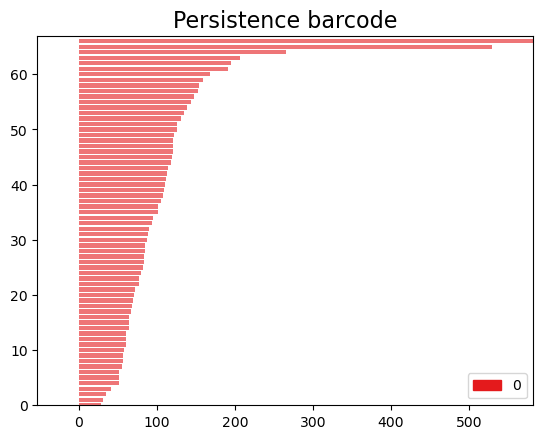

<Figure size 600x600 with 0 Axes>

In [175]:
gudhi.plot_persistence_barcode(simplex.persistence(), legend=True)
plt.figure(figsize=(6,6))
plt.show()

Track connected components along with genomic coords of their constituents - which loci connect at different radii, what is maximum genomic distance covered in each component. Main thing is a way to map the dots above ^ back to the metadata and identity of their components.